<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_AdvectionDiffusion_GaussianSource_x0_1_t0_1_IMEX_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN for 1D Advection–Diffusion with a Localized Gaussian Source  
## Ground truth: IMEX (Explicit Upwind Advection + Crank–Nicolson Diffusion)

We solve and learn the PDE:
\[
c_t + u\,c_x = D\,c_{xx} + s(x,t),\qquad x\in(0,L),\ t\in[0,T].
\]

**Problem (fixed):**
- \(L=2\), \(N=1000\Rightarrow \Delta x=L/N=0.002\)
- \(u=1\), \(D=\tfrac12\)
- IC: \(c(x,0)=x\)
- Dirichlet BCs: \(c(0,t)=0\), \(c(L,t)=L=2\)

**Source (Gaussian in space-time):**
\[
s(x,t)=A\exp\!\Big(-\tfrac12\big(\tfrac{x-x_0}{\sigma_x}\big)^2\Big)\exp\!\Big(-\tfrac12\big(\tfrac{t-t_0}{\sigma_t}\big)^2\Big)
\]
with **updated center**: \(x_0=1\), \(t_0=1\).

This notebook contains:
1) Ground-truth solver (IMEX: Upwind + Crank–Nicolson) using the Thomas algorithm  
2) Dataset creation (IC/BC/collocation + supervised points from ground truth)  
3) PINN (PyTorch) with residual including the source term  
4) Training + evaluation plots


In [1]:
# =========================
# 0) Imports & Reproducibility
# =========================
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataclasses import dataclass
from typing import Tuple, Callable

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 1) Configuration

In [2]:
# =========================
# 1) Configuration
# =========================
SRC = (3.0, 1.0, 0.5, 1.0, 0.2)  # (A, x0, sx, t0, st) with x0=1, t0=1

@dataclass
class Params:
    # PDE
    L: float = 2.0
    N: int = 1000
    u: float = 1.0
    D: float = 0.5
    T: float = 2.0       # covers t0=1 comfortably
    dt: float = 1e-3     # advection CFL: u*dt/dx <= 1

    # Source
    A: float = SRC[0]
    x0: float = SRC[1]
    sx: float = SRC[2]
    t0: float = SRC[3]
    st: float = SRC[4]

    # Dataset sizes
    n_f: int = 25000     # collocation points (PDE residual)
    n_ic: int = 4000     # initial condition points
    n_bc: int = 4000     # boundary condition points (split left/right)
    n_data: int = 12000  # supervised samples from ground truth (optional but helpful)

    # Training
    epochs: int = 6000
    lr: float = 1e-3
    print_every: int = 300

p = Params()

dx = p.L / p.N
cfl = abs(p.u) * p.dt / dx
mu = p.D * p.dt / dx**2

print(f"dx = {dx}")
print(f"CFL = {cfl}")
print(f"mu  = {mu}")
assert cfl <= 1.0 + 1e-12, "CFL violated (explicit upwind advection). Reduce dt."


dx = 0.002
CFL = 0.5
mu  = 125.00000000000001


## 2) Source definition

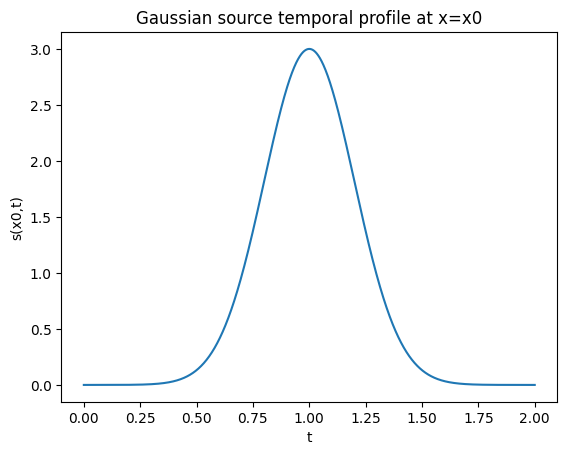

In [3]:
# =========================
# 2) Gaussian source (NumPy + PyTorch)
# =========================
def gaussian_source_np(x: np.ndarray, t: float, A: float, x0: float, sx: float, t0: float, st: float) -> np.ndarray:
    """s(x,t) evaluated on x-array and scalar t."""
    return A * np.exp(-0.5 * ((x - x0) / sx) ** 2) * np.exp(-0.5 * ((t - t0) / st) ** 2)

def gaussian_source_torch(x: torch.Tensor, t: torch.Tensor, A: float, x0: float, sx: float, t0: float, st: float) -> torch.Tensor:
    """s(x,t) evaluated on torch tensors (column vectors)."""
    return A * torch.exp(-0.5 * ((x - x0) / sx) ** 2) * torch.exp(-0.5 * ((t - t0) / st) ** 2)

# Visual sanity: temporal profile at x=x0 (space factor=1)
ts = np.linspace(0, p.T, 2001)
s_peak = p.A * np.exp(-0.5 * ((ts - p.t0) / p.st) ** 2)
plt.figure()
plt.plot(ts, s_peak)
plt.xlabel('t'); plt.ylabel('s(x0,t)')
plt.title('Gaussian source temporal profile at x=x0')
plt.show()


## 3) Ground truth solver: IMEX (Upwind + Crank–Nicolson)

We discretize on a uniform grid. For interior nodes \(i=1..N-1\):

- **Upwind advection (explicit)** for \(u>0\):
\[
A_i^n = \lambda (c_i^n - c_{i-1}^n),\qquad \lambda=\frac{u\Delta t}{\Delta x}.
\]

- **Crank–Nicolson diffusion (implicit)** produces a tridiagonal system with \(\mu = D\Delta t/\Delta x^2\):

\[
-\frac{\mu}{2}c_{i-1}^{n+1} + (1+\mu)c_i^{n+1} - \frac{\mu}{2}c_{i+1}^{n+1}
= (1-\mu)c_i^n + \frac{\mu}{2}(c_{i-1}^n+c_{i+1}^n) - A_i^n + \Delta t\,s(x_i,t^n).
\]

Dirichlet BCs:
- \(c(0,t)=0\)
- \(c(L,t)=L\)


In [4]:
# =========================
# 3) Thomas algorithm (tridiagonal solver)
# =========================
def thomas_solve(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    """Solve tridiagonal system with Thomas algorithm.

    a: lower diag (len m-1)
    b: main diag  (len m)
    c: upper diag (len m-1)
    d: RHS        (len m)
    """
    m = b.size
    cp = np.empty(m-1, dtype=float)
    dp = np.empty(m, dtype=float)

    denom = b[0]
    cp[0] = c[0] / denom
    dp[0] = d[0] / denom

    for i in range(1, m-1):
        denom = b[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / denom

    denom = b[m-1] - a[m-2] * cp[m-2] if m > 1 else b[m-1]
    dp[m-1] = (d[m-1] - (a[m-2] * dp[m-2] if m > 1 else 0.0)) / denom

    x = np.empty(m, dtype=float)
    x[m-1] = dp[m-1]
    for i in range(m-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x


In [5]:
# =========================
# 4) IMEX solver: Upwind advection (explicit) + CN diffusion (implicit) + source
# =========================
def solve_imex_cn_upwind_with_source(
    L: float, N: int, u: float, D: float, T: float, dt: float,
    source_fn: Callable[[np.ndarray, float], np.ndarray],
    g0_fn: Callable[[float], float],
    gL_fn: Callable[[float], float],
    ic_fn: Callable[[np.ndarray], np.ndarray],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dx = L / N
    Nt = int(np.round(T / dt))
    t = np.linspace(0.0, Nt * dt, Nt + 1)
    x = np.linspace(0.0, L, N + 1)

    lam = u * dt / dx
    mu = D * dt / dx**2

    # solution array
    C = np.zeros((Nt + 1, N + 1), dtype=float)

    # initial condition
    C[0, :] = ic_fn(x)
    C[0, 0] = g0_fn(0.0)
    C[0, -1] = gL_fn(0.0)

    # tridiagonal coefficients (constant) for interior size m=N-1
    m = N - 1
    a = (-mu / 2.0) * np.ones(m - 1)      # lower
    b = (1.0 + mu) * np.ones(m)           # main
    c = (-mu / 2.0) * np.ones(m - 1)      # upper

    for n in range(Nt):
        tn = t[n]
        tnp1 = t[n + 1]

        # enforce BCs at time n
        C[n, 0] = g0_fn(tn)
        C[n, -1] = gL_fn(tn)

        # explicit upwind advection term A_i^n (interior i=1..N-1)
        if u >= 0:
            Aadv = lam * (C[n, 1:N] - C[n, 0:N-1])
        else:
            Aadv = lam * (C[n, 2:N+1] - C[n, 1:N])

        # explicit source at time n, interior points
        S = source_fn(x[1:N], tn)

        rhs = (1.0 - mu) * C[n, 1:N] + (mu / 2.0) * (C[n, 0:N-1] + C[n, 2:N+1]) - Aadv + dt * S

        # Dirichlet BCs at time n+1 shift RHS
        c0_np1 = g0_fn(tnp1)
        cL_np1 = gL_fn(tnp1)
        rhs[0]  += (mu / 2.0) * c0_np1
        rhs[-1] += (mu / 2.0) * cL_np1

        # solve for interior at n+1
        interior = thomas_solve(a, b, c, rhs)

        # write solution
        C[n + 1, 0] = c0_np1
        C[n + 1, 1:N] = interior
        C[n + 1, -1] = cL_np1

    return x, t, C


# Bind PDE/IC/BC/source
g0 = lambda tt: 0.0
gL = lambda tt: p.L
ic = lambda xx: xx  # c(x,0)=x
source = lambda xarr, tt: gaussian_source_np(xarr, tt, p.A, p.x0, p.sx, p.t0, p.st)

# Compute ground truth
x, t, C = solve_imex_cn_upwind_with_source(p.L, p.N, p.u, p.D, p.T, p.dt, source, g0, gL, ic)
print("Shapes:", x.shape, t.shape, C.shape)


Shapes: (1001,) (2001,) (2001, 1001)


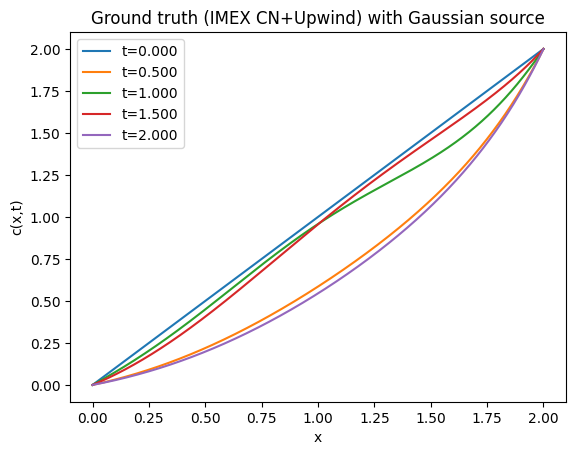

In [6]:
# =========================
# 5) Quick visual checks
# =========================
def plot_solution_slices(times):
    plt.figure()
    for tt in times:
        idx = int(round(tt / p.dt))
        idx = max(0, min(idx, len(t)-1))
        plt.plot(x, C[idx], label=f"t={t[idx]:.3f}")
    plt.xlabel("x"); plt.ylabel("c(x,t)")
    plt.legend()
    plt.title("Ground truth (IMEX CN+Upwind) with Gaussian source")
    plt.show()

plot_solution_slices([0.0, 0.5, 1.0, 1.5, 2.0])


## 4) Dataset creation for PINN

In [7]:
# =========================
# 6) Sampling helpers
# =========================
def sample_ic(n: int, L: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    xs = np.random.rand(n) * L
    ts = np.zeros_like(xs)
    cs = xs.copy()
    return xs, ts, cs

def sample_bc(n: int, L: float, T: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    nL = n // 2
    nR = n - nL

    tL = np.random.rand(nL) * T
    xL = np.zeros_like(tL)
    cL = np.zeros_like(tL)

    tR = np.random.rand(nR) * T
    xR = np.ones_like(tR) * L
    cR = np.ones_like(tR) * L

    xs = np.concatenate([xL, xR])
    ts = np.concatenate([tL, tR])
    cs = np.concatenate([cL, cR])
    return xs, ts, cs

def sample_collocation(n: int, L: float, T: float) -> Tuple[np.ndarray, np.ndarray]:
    xs = np.random.rand(n) * L
    ts = np.random.rand(n) * T
    return xs, ts

def sample_data_from_grid(n: int, xgrid: np.ndarray, tgrid: np.ndarray, Cgrid: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    tidx = np.random.randint(0, tgrid.size, size=n)
    xidx = np.random.randint(0, xgrid.size, size=n)
    xs = xgrid[xidx]
    ts = tgrid[tidx]
    cs = Cgrid[tidx, xidx]
    return xs, ts, cs

def to_torch(a: np.ndarray) -> torch.Tensor:
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1, 1)


In [8]:
# =========================
# 7) Create datasets
# =========================
x_ic, t_ic, c_ic = sample_ic(p.n_ic, p.L)
x_bc, t_bc, c_bc = sample_bc(p.n_bc, p.L, p.T)
x_f,  t_f        = sample_collocation(p.n_f, p.L, p.T)
x_d,  t_d,  c_d  = sample_data_from_grid(p.n_data, x, t, C)

X_ic = torch.cat([to_torch(x_ic), to_torch(t_ic)], dim=1)
Y_ic = to_torch(c_ic)

X_bc = torch.cat([to_torch(x_bc), to_torch(t_bc)], dim=1)
Y_bc = to_torch(c_bc)

X_f  = torch.cat([to_torch(x_f),  to_torch(t_f)],  dim=1)

X_d  = torch.cat([to_torch(x_d),  to_torch(t_d)],  dim=1)
Y_d  = to_torch(c_d)

print("IC:", X_ic.shape, "BC:", X_bc.shape, "F:", X_f.shape, "Data:", X_d.shape)


IC: torch.Size([4000, 2]) BC: torch.Size([4000, 2]) F: torch.Size([25000, 2]) Data: torch.Size([12000, 2])


## 5) PINN model and PDE residual (with source)

In [9]:
# =========================
# 8) PINN model
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=128, depth=6, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)

model = MLP(width=128, depth=6).to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [10]:
# =========================
# 9) PDE residual with source: r = c_t + u c_x - D c_xx - s(x,t)
# =========================
def pde_residual_with_source(model: nn.Module, X: torch.Tensor, u: float, D: float,
                             A: float, x0: float, sx: float, t0: float, st: float) -> torch.Tensor:
    X = X.clone().requires_grad_(True)
    c = model(X)  # (n,1)

    grads = torch.autograd.grad(c, X, torch.ones_like(c), create_graph=True, retain_graph=True)[0]
    c_x = grads[:, 0:1]
    c_t = grads[:, 1:2]

    c_xx = torch.autograd.grad(c_x, X, torch.ones_like(c_x), create_graph=True, retain_graph=True)[0][:, 0:1]

    s = gaussian_source_torch(X[:, 0:1], X[:, 1:2], A, x0, sx, t0, st)
    r = c_t + u * c_x - D * c_xx - s
    return r


## 6) Training

In [11]:
# =========================
# 10) Training loop
# =========================
w_f = 1.0
w_ic = 10.0
w_bc = 10.0
w_data = 1.0   # set to 0 for a pure PINN run

opt = torch.optim.Adam(model.parameters(), lr=p.lr)
loss_hist = []

for epoch in range(1, p.epochs + 1):
    model.train()
    opt.zero_grad()

    pred_ic = model(X_ic)
    pred_bc = model(X_bc)
    pred_d  = model(X_d)

    loss_ic = torch.mean((pred_ic - Y_ic) ** 2)
    loss_bc = torch.mean((pred_bc - Y_bc) ** 2)
    loss_d  = torch.mean((pred_d  - Y_d)  ** 2)

    r = pde_residual_with_source(model, X_f, p.u, p.D, p.A, p.x0, p.sx, p.t0, p.st)
    loss_f = torch.mean(r ** 2)

    loss = w_f * loss_f + w_ic * loss_ic + w_bc * loss_bc + w_data * loss_d
    loss.backward()
    opt.step()

    loss_hist.append([loss.item(), loss_f.item(), loss_ic.item(), loss_bc.item(), loss_d.item()])

    if epoch % p.print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | total {loss.item():.3e} | f {loss_f.item():.3e} | ic {loss_ic.item():.3e} | bc {loss_bc.item():.3e} | data {loss_d.item():.3e}")


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch     1 | total 3.899e+01 | f 7.621e-01 | ic 1.521e+00 | bc 2.188e+00 | data 1.136e+00
Epoch   300 | total 7.588e-01 | f 6.797e-01 | ic 1.818e-03 | bc 1.689e-03 | data 4.402e-02
Epoch   600 | total 5.012e-01 | f 4.151e-01 | ic 2.740e-04 | bc 7.149e-03 | data 1.183e-02
Epoch   900 | total 3.594e-01 | f 2.949e-01 | ic 1.003e-03 | bc 4.925e-03 | data 5.202e-03
Epoch  1200 | total 1.798e-01 | f 1.406e-01 | ic 2.134e-04 | bc 3.381e-03 | data 3.216e-03
Epoch  1500 | total 7.042e-02 | f 5.069e-02 | ic 1.959e-04 | bc 1.441e-03 | data 3.366e-03
Epoch  1800 | total 9.838e-02 | f 1.199e-02 | ic 3.599e-03 | bc 4.805e-03 | data 2.347e-03
Epoch  2100 | total 5.011e-01 | f 1.654e-02 | ic 1.894e-02 | bc 2.784e-02 | data 1.676e-02
Epoch  2400 | total 5.539e-03 | f 3.459e-03 | ic 4.691e-05 | bc 1.570e-04 | data 4.039e-05
Epoch  2700 | total 3.332e-03 | f 2.180e-03 | ic 3.962e-05 | bc 7.390e-05 | data 1.680e-05
Epoch  3000 | total 2.537e-03 | f 1.693e-03 | ic 3.463e-05 | bc 4.862e-05 | data 1.105e-05

## 7) Evaluation (selected time slices)

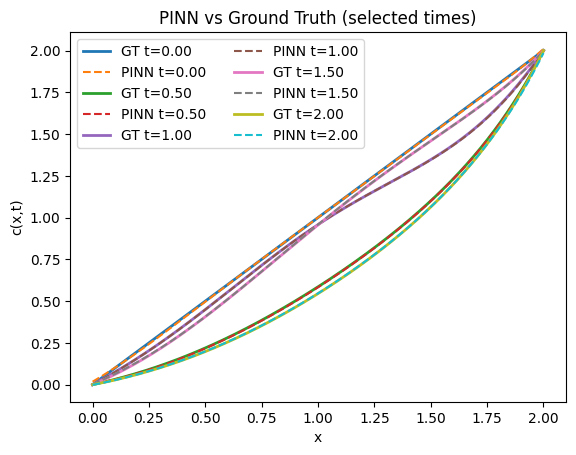

Relative L2 error (evaluated slices): 0.0026181042355005006
MAE (evaluated slices): 0.0018799111587319488


In [12]:
# =========================
# 11) Prediction helper + slice comparison
# =========================
model.eval()

def predict_on_grid(x_grid: np.ndarray, t_grid: np.ndarray, batch: int = 200000) -> np.ndarray:
    TT, XX = np.meshgrid(t_grid, x_grid, indexing='ij')  # (Nt, Nx)
    Xt = torch.tensor(np.column_stack([XX.ravel(), TT.ravel()]), dtype=torch.float32, device=device)

    preds = []
    with torch.no_grad():
        for i in range(0, Xt.shape[0], batch):
            preds.append(model(Xt[i:i+batch]).detach().cpu().numpy())
    return np.concatenate(preds, axis=0).reshape(t_grid.size, x_grid.size)

times_eval = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
t_idx = np.clip((times_eval / p.dt).round().astype(int), 0, t.size - 1)
t_eval = t[t_idx]

pred_eval = predict_on_grid(x, t_eval)

plt.figure()
for k, tt in enumerate(t_eval):
    plt.plot(x, C[t_idx[k]], label=f"GT t={tt:.2f}", linewidth=2)
    plt.plot(x, pred_eval[k], '--', label=f"PINN t={tt:.2f}")
plt.xlabel('x'); plt.ylabel('c(x,t)')
plt.legend(ncol=2)
plt.title('PINN vs Ground Truth (selected times)')
plt.show()

err = pred_eval - C[t_idx]
rel_l2 = np.linalg.norm(err.ravel()) / np.linalg.norm(C[t_idx].ravel())
mae = np.mean(np.abs(err))
print('Relative L2 error (evaluated slices):', rel_l2)
print('MAE (evaluated slices):', mae)


## 8) Training curves

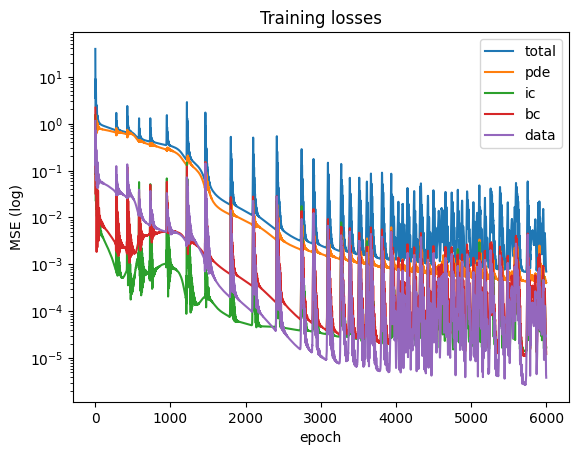

In [13]:
# =========================
# 12) Loss curves
# =========================
loss_hist = np.array(loss_hist)
plt.figure()
plt.semilogy(loss_hist[:, 0], label='total')
plt.semilogy(loss_hist[:, 1], label='pde')
plt.semilogy(loss_hist[:, 2], label='ic')
plt.semilogy(loss_hist[:, 3], label='bc')
plt.semilogy(loss_hist[:, 4], label='data')
plt.xlabel('epoch'); plt.ylabel('MSE (log)')
plt.title('Training losses')
plt.legend()
plt.show()
